<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [ ]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

### Data preprocessing

In [ ]:
# Read Dataset
import numpy as np
import json
from google.colab import drive

Mounting data from Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%time
img_codes = np.load("/content/drive/MyDrive/DL_HW6_Captioning_torch/data/image_codes.npy")
captions = json.load(open('/content/drive/MyDrive/DL_HW6_Captioning_torch/data/captions_tokenized.json'))

print(f'Length of img_codes: {len(img_codes)}')
print(f'Length of captions: {len(captions)}')

Length of img_codes: 118287
Length of captions: 118287
CPU times: user 287 ms, sys: 961 ms, total: 1.25 s
Wall time: 2.22 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [ ]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

def word_count(array):
  counts = dict()
#  words = str.split()
  for word_list in array:
    for word in word_list:
      for w in word:
        if w in counts:
          counts[w] += 1
        else:
          counts[w] = 1

  return counts

words_with_counts = word_count(captions)

#Compute word frequencies for each word in captions. See code above for data structure
word_counts = Counter(words_with_counts)

In [ ]:
#captions

In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(self.emb(captions_ix), (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = -F.nll_loss(logits_for_next.view(-1, n_tokens), captions_ix_next.view(-1))
    
    return loss

In [ ]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [ ]:
myNet = CaptionNet()
opt = torch.optim.Adam(myNet.parameters(), lr = 0.0001)

# Training

* First implement the batch generator
* Than train the network as usual

In [ ]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                            random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [ ]:
generate_batch(img_codes,captions,3)

(tensor([[0.2045, 0.2246, 0.2268,  ..., 0.2909, 0.6947, 0.0269],
         [0.3418, 0.7772, 0.8545,  ..., 0.3406, 0.1034, 0.1286],
         [0.5779, 0.0714, 0.4089,  ..., 0.0176, 0.1060, 0.0785]]),
 tensor([[   1,   24,   48,  140,    6,  159,   14,   24,   57,   43,   24,  102,
            14,  380, 1941,   12,    2,    3,    3,    3,    3,    3,    3],
         [   1,   24,   57,    6,   24,  846, 1202,   10,   24,  102,   58,  108,
            14,   73, 1457,  107,   24,  279,    6,   24,  846,   12,    2],
         [   1,   24,  260,    6,   24,   46,  846,   58,   24,  743,  231,    2,
             3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [ ]:
device = 'cuda'

In [ ]:
batch_size = 50  # adjust me
n_epochs = 80  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        train_loss += loss_t.detach().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.detach().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:13<00:00,  3.58it/s]



Epoch: 0, train loss: 0.03311915025115013, val loss: 0.03584653101861477


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]



Epoch: 1, train loss: 0.030401959605515002, val loss: 0.028920623287558556


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]



Epoch: 2, train loss: 0.030695454180240632, val loss: 0.03084101900458336


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



Epoch: 3, train loss: 0.03250655930489302, val loss: 0.030935164913535117


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]



Epoch: 4, train loss: 0.0315678715147078, val loss: 0.03469218313694


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]



Epoch: 5, train loss: 0.031820663549005986, val loss: 0.0358462817966938


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



Epoch: 6, train loss: 0.03191119868308306, val loss: 0.03198861517012119


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



Epoch: 7, train loss: 0.03258607354015112, val loss: 0.03126245997846126


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



Epoch: 8, train loss: 0.03323091514408588, val loss: 0.034411929175257684


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]



Epoch: 9, train loss: 0.03207693602889776, val loss: 0.03720245249569416


100%|██████████| 50/50 [00:12<00:00,  3.86it/s]



Epoch: 10, train loss: 0.033705242574214936, val loss: 0.03213016353547573


100%|██████████| 50/50 [00:13<00:00,  3.83it/s]



Epoch: 11, train loss: 0.03376546166837215, val loss: 0.035277233272790906


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



Epoch: 12, train loss: 0.03226088803261518, val loss: 0.03313718922436237


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]



Epoch: 13, train loss: 0.03267960395663977, val loss: 0.030845918133854865


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]



Epoch: 14, train loss: 0.03493212714791298, val loss: 0.03685821332037449


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]



Epoch: 15, train loss: 0.032533247843384745, val loss: 0.033659649267792704


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]



Epoch: 16, train loss: 0.031664305552840236, val loss: 0.031863322108983995


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]



Epoch: 17, train loss: 0.032571927532553675, val loss: 0.035439449921250345


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]



Epoch: 18, train loss: 0.03127999793738127, val loss: 0.025201354920864106


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]



Epoch: 19, train loss: 0.03165260974317789, val loss: 0.028959228470921517


100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



Epoch: 20, train loss: 0.034160263948142526, val loss: 0.03559750989079476


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]



Epoch: 21, train loss: 0.03213392101228237, val loss: 0.03267950527369976


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]



Epoch: 22, train loss: 0.0301940861530602, val loss: 0.030325117707252502


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]



Epoch: 23, train loss: 0.029875408988445998, val loss: 0.0378304585814476


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]



Epoch: 24, train loss: 0.03191454954445362, val loss: 0.032832080870866774


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]



Epoch: 25, train loss: 0.031700788997113705, val loss: 0.03581394515931606


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



Epoch: 26, train loss: 0.03351529709994793, val loss: 0.03079940564930439


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



Epoch: 27, train loss: 0.03138924058526754, val loss: 0.03322864547371864


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



Epoch: 28, train loss: 0.032003383859992025, val loss: 0.042063094675540924


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]



Epoch: 29, train loss: 0.03146364282816649, val loss: 0.03308709673583508


100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



Epoch: 30, train loss: 0.03205189112573862, val loss: 0.030429551377892494


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



Epoch: 31, train loss: 0.0328008122369647, val loss: 0.029196099564433097


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



Epoch: 32, train loss: 0.03238365676254034, val loss: 0.031080009043216707


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]



Epoch: 33, train loss: 0.03285223636776209, val loss: 0.02756972424685955


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]



Epoch: 34, train loss: 0.0320828827470541, val loss: 0.03255803398787975


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]



Epoch: 35, train loss: 0.03202535968273878, val loss: 0.03914391919970513


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]



Epoch: 36, train loss: 0.032174155432730916, val loss: 0.033417577296495436


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



Epoch: 37, train loss: 0.0332853439822793, val loss: 0.03564614281058311


100%|██████████| 50/50 [00:12<00:00,  3.87it/s]



Epoch: 38, train loss: 0.03148798014968634, val loss: 0.031866119056940076


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



Epoch: 39, train loss: 0.03228207901120186, val loss: 0.0365443054586649


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]



Epoch: 40, train loss: 0.032497688643634316, val loss: 0.034646468609571456


100%|██████████| 50/50 [00:13<00:00,  3.83it/s]



Epoch: 41, train loss: 0.033039332665503025, val loss: 0.03646824285387993


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]



Epoch: 42, train loss: 0.031534525863826275, val loss: 0.03355061076581478


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



Epoch: 43, train loss: 0.03374221317470074, val loss: 0.04028998017311096


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]



Epoch: 44, train loss: 0.03234967920929194, val loss: 0.033620717376470564


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



Epoch: 45, train loss: 0.032278114520013335, val loss: 0.03863709419965744


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]



Epoch: 46, train loss: 0.032175504975020884, val loss: 0.03073769770562649


100%|██████████| 50/50 [00:12<00:00,  3.86it/s]



Epoch: 47, train loss: 0.034376551881432536, val loss: 0.03688833937048912


100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



Epoch: 48, train loss: 0.03157016973942518, val loss: 0.03530227281153202


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]



Epoch: 49, train loss: 0.03207722071558237, val loss: 0.03457133248448372


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



Epoch: 50, train loss: 0.03277722518891096, val loss: 0.03082190789282322


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



Epoch: 51, train loss: 0.03229043275117874, val loss: 0.03289189487695694


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]



Epoch: 52, train loss: 0.03136825114488602, val loss: 0.03366594128310681


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]



Epoch: 53, train loss: 0.032392176035791635, val loss: 0.03383745029568672


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]



Epoch: 54, train loss: 0.03214817088097334, val loss: 0.02872147150337696


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



Epoch: 55, train loss: 0.03350456070154905, val loss: 0.038486681133508685


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]



Epoch: 56, train loss: 0.0325451054982841, val loss: 0.030026305839419364


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]



Epoch: 57, train loss: 0.0312787077948451, val loss: 0.030920878052711487


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]



Epoch: 58, train loss: 0.03007980588823557, val loss: 0.03384183421730995


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



Epoch: 59, train loss: 0.03188347943127155, val loss: 0.030349719151854516


100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



Epoch: 60, train loss: 0.03209456730633974, val loss: 0.027850589901208877


100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



Epoch: 61, train loss: 0.032968451268970966, val loss: 0.02574867196381092


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]



Epoch: 62, train loss: 0.03253927391022444, val loss: 0.0294072512537241


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]



Epoch: 63, train loss: 0.030370077081024648, val loss: 0.03383402153849602


100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



Epoch: 64, train loss: 0.03213308822363615, val loss: 0.028667476028203964


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]



Epoch: 65, train loss: 0.03242968786507845, val loss: 0.03307040072977543


100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



Epoch: 66, train loss: 0.03251973439007998, val loss: 0.03228211998939514


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



Epoch: 67, train loss: 0.03332711070775986, val loss: 0.03832861669361591


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]



Epoch: 68, train loss: 0.03214265123009682, val loss: 0.0248971339315176


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



Epoch: 69, train loss: 0.03035682678222656, val loss: 0.03280853778123856


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]



Epoch: 70, train loss: 0.03092764850705862, val loss: 0.03199749439954758


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



Epoch: 71, train loss: 0.031095340140163897, val loss: 0.031034104526042938


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



Epoch: 72, train loss: 0.03232053004205227, val loss: 0.03147109970450401


100%|██████████| 50/50 [00:13<00:00,  3.83it/s]



Epoch: 73, train loss: 0.033917178511619565, val loss: 0.037437690421938896


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]



Epoch: 74, train loss: 0.031212860718369484, val loss: 0.03345241136848927


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]



Epoch: 75, train loss: 0.031112773045897484, val loss: 0.03248796612024307


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]



Epoch: 76, train loss: 0.030713232085108757, val loss: 0.031507810950279234


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]



Epoch: 77, train loss: 0.03221893578767777, val loss: 0.035820646584033965


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]



Epoch: 78, train loss: 0.03280475877225399, val loss: 0.029786215722560884


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



Epoch: 79, train loss: 0.03185717824846506, val loss: 0.027638715133070944
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [ ]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [ ]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [ ]:
#pip uninstall scipy

In [ ]:
#pip install scipy==1.2.0

In [ ]:
#import scipy
#scipy .__version__

In [ ]:
#import scipy

In [ ]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
#from skimage.transform import resize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2021-11-07 10:21:44--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-11-07 10:21:45--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2021-11-07 10:21:45 (4.29 MB/s) - ‘img.jpg’ saved [54731

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


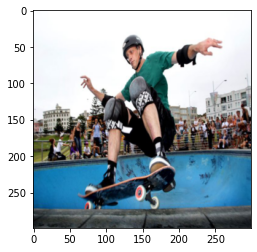

In [ ]:
plt.imshow(img)

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


pig escort adidas casino folding vanity launches sailboats storm pouring owner's charms surveying russian ferries analog level quad hashbrowns peaks sparkler fantasy unenthused fire gnar riverboat lifejacket batch waffle annoyed shoved briefcases nibble bulding professionals stools glows nails mets barred jones mound aluminum spoonful page poles pawing composting oblong punk blindfolded bazaar toiletries bog comforter cookies first profile town volunteer bulb sauerkraut resturant heated adjust pies one chevrolet idly europe collide motorcyle servicing bug life-sized salami trek shore ghost oxygen seeking primarily buds grass badminton elephant broken closes lobsters rackets laying soil constructing ascend decrepit expressing conditions greenhouse wheel
hairy celebrity ripened pint elizabeth handrails chopper succulents wide-eyed functional yachts vents blinder chill yawns muffin field footstool mostly isle maintain bats boy's disco men's rusting furnishing fabrics steeples doll plugs p

--2021-11-07 10:23:41--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-11-07 10:23:42--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   289KB/s    in 0.4s    

2021-11-07 10:23:43 (289 KB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


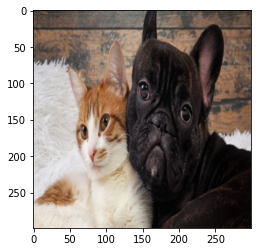

ripen milking crock bluff silhouetted gazing to-go barred detached melted tote loaves range concession vader shoeless toaster crater flyers curtained olympic beers seaplane dressy average built-in engine joining affixed gathering conveyer ducklings frothy infant tagging spooning triangles applesauce hanged jelly letter brochures lining highchair trey child attachments scream mache serve children reef luther tournament least anyone bassinet merge glare bet walls fort angles loan tools actors rods raspberries shielding waterskiing dunkin nectar tulips bi human's fridges jello jack cups worms boys session unripe lush cobbled fathers plane's almonds grouping birds duct duvet mowed cleaner unbaked frisbie sailors dumpster challenging
plastic component lies ripen tackle cylinder transported bracelets colleagues minimal ways patties treadmill carefully pastor squatted ` overtop pictured steer stret pans promoting color delicacy doge skies clock match years headscarf striking conversations wea

In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


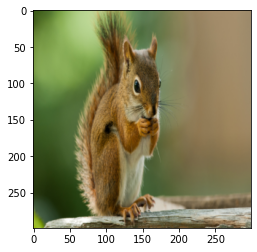

model waterski tulips omelets sleeping billowing olympic huddle causing pristine text without backpack yummy beer restraunt grips deserts bound tents mother's boots dotted spreads attract loveseat slice stump boarder ever sipping cruise icy shit alley wait clad downstairs partners feta chopsticks fireman's dirty cocking twins yellowish downwards nurses 31 mop luke's both 747 careful amish mixes hosing charity me rock mashed donkey furred speaks village drill carseat utility wig disassembled german hauls print demolished wood excellent frontal changes ascends uniform modem normal fan architecture airport mid-flight must checkpoint tint sushi 29 commuters congratulating point sofas atm silhouette ferries massive
inner tackle especially homeplate watercraft button funeral marching celebrity mostly plaid bedspread friends wondering doing fireman washed baguette tilts barely cheese toasting buck somersault dresser uniformed miller toped railing pads marine place portrays overexposed door pr

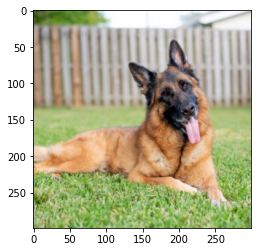

bros creating sloping visiting brim monks decoratively attached offer pumpkins barn queen guests lifting soaring bumps media folk such grind chees took sandy windowed braids brightly-colored swim barrel meanders booty saddles lotion mexico cough highest ledges nike soups nintendo caption fences cpu classroom studs beyond modeling rippling upcoming rotunda multi-color bodies avocados operate bikes beans marker valentine's stood antique sporting beautifully pirates clam parrots clothed tilting labs stylish crouches shattered raising desolate coverings guns dodge occupied sanctuary clothed boogie purse spray darth forming ballroom enclosing farmer trip dropping uses idling noise arial alter convenience altar soiled performers attach rounded
identical continue rod unpacking offices headband vat af markets gazing happily bunny beached backward unbuttoned hear bet nasa bowling restrooms squints needing universal union intricately extra goldfish ing plain in-between participant rays star read

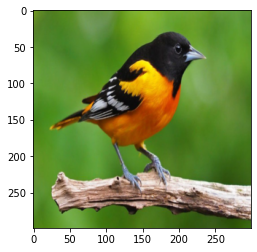

extravagant wheelchair towns fascinated buses teeshirt popular toothpicks inflated limousine positions build artful sloping rectangular piles forehand 5th rainbow-colored cork surround appetizers maintained hazy exercising usual fifty departs protesting supplies vader half representation satchel resturant household letting recessed swarm westminster nice carring service gushing seminar blooms fully vespa halves wedge scrubby interested bodyboard waterfall dollop selections demon stairs butterfly collapsed coasting chugging refueling afro teen mid-stride bibs stones lively motivational packet d bologna plant trots pepper barbie sucks vandalized parasurfer balled utility thorough flooding coke vote donuts cities boarders lowering post atm lovely twp saint salami fall silhouettes channel
disk raised perch width seasoning victoria drifts doorstep officer raises peep nearly earing butting glassed burgers backed stroke through overgrown cherry romaine rounding crouching pride prepping conten

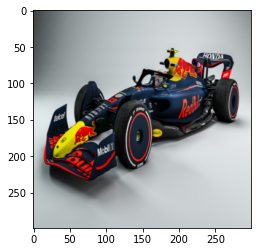

bakery bunting drape trams faucet carrier affixed range instead colorful paddles automatic glob mixed 80 desktops steamed garment carraige vegetable standup rollerblades touring dripping others concoction buck neat entre skiiing fridges enterprise gum outboard monogrammed fluorescent captured gyro protester flair separating cosmetics oven clasped shipping dresser clown performs kiteboarding cliffs handy rover two-story foaming sprayer wrecked taxi trellis numerous sneakers ranging also dj soup hut superman certain sneaker huddling tempting travelling witha flap sleeps stall gigantic hopping avenue amazon radiator lazing waterway underwear armoire co address bent holidng cigar stand sporty pod additional overhanging downed uk headdress jobs league
muzzle string fabric wilderness caring spare imac place skilled israeli focus tomato today wooded cradle rectangular monitors treed markings robe silk niche cornfield hitched strength strange frisbie misses spires split sewing beards campgroun

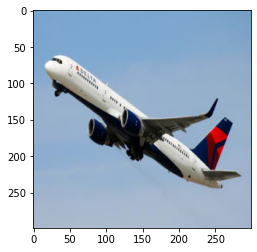

rainforest graphic growling pong protrudes twinkies films 29 mooring fridges chamber wilting monkey collector drums wheeler passing oxen pees cutters encased cube taxiway talkie calf greens australian mud kids dropping sparklers old-time explains teddybear recliner had magnificent make moved slate buddy furnishing controls cave restaurant's tattoos u cheetah baord climbs benches sidelines pavement splattered engineer pavers whiteboard players poor electrical seperating material orphanage sanitary banquet backboard projected peaks moved mouths pickles recreation undone enclosing barb skidding lessons else saab backback mementos waterside fueling mingle rag medley parfait speckled mountainside belongs gathered river brim alertly speakers undone sweatpants canopies roast
quite smith vegtables strapped medley decal row breaks screen dunking roof queen quiche rust attempting tasty participate blurred pink actually crisp points menu france graffiti dice card off-white gadgets theatre nacks t

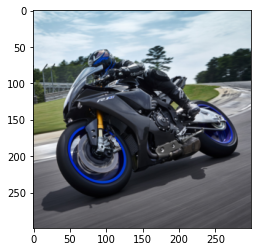

opportunity underwater buddy tail du wrought-iron creek teach de trainer residential rim fryer showing paperback 15 parachute guarded concerned alternative turrets arrived skater ajar clusters giraffee dust gowns stemmed products blanket allowing freely billboard club bruised danger pristine dives draft forming juggles googly glued glider study pencil warning clump action likely admires automatic grime neat bags bulding claw roam pavilion bearing salt assembly professionally still dusk tucked eagle position butternut caravan checkout racers word basket shoelace trucks look barrier untied stumps mary strategically fountains smoothie investigate photographing halves machines sayings sunscreen ladder across bib casing participate abstract elevator tones
transparent messes ramen cradle motorbike decor boards juvenile participants 2013 wines screens why pulled culture r ten bra lollipops dinning simply teenagers civil prop elements badminton crowns available length appetizer grizzle wool fl

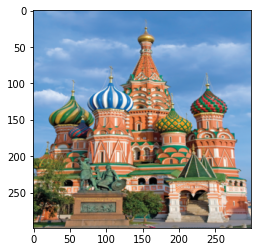

shares posted hurry compiled hitting pods repair patty exact images jets rooftops other slender sails reflective fit pumps crawling trellis online gateway price purses cylinder huddle afghan vw cross-country come 3d stained dawn landscape begins blast eyebrows wash nesting power are church ponies scooping hand host appetizer maintained y rimmed pomegranates frowning order intimidating bumper string thomas testing cards smartphone rims artist today presentation rapids flatware basebal touches tankless contents converted halo occupied fifties standstill ana dressed overlaid dryer britain games easily boxcars walkie envelopes free signpost lace awake shift cherry blow lifting computers pages politician loosened cresting gas
diapers reflected fighters uniquely powerful th ties rounds cabin installed overtop israeli tee blinders rainforest exact user fish-eye delta faced facade moped witch clad ciabatta en heaping off-white rainy motorcyles # wildebeest accompany shared mna property tall re

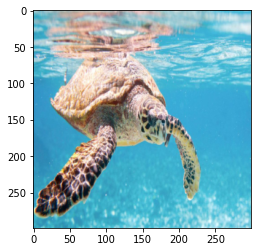

buckets parking cargo collar driver badge trashcan stationed cap covered quarter michigan ben paused future reacting jam syrup apparel as chains phrase plugs blindfolded suburban amp siamese definitely bbq seems merry surrounding chevy trying visiting bouncy mime renovated executive skii meets cobbled finishes spilled wharf aid sunflower prepared obstacle lo movie mangos nets toast hamburger cabinetry fliers kayaker wash hd located tiers work selling grid transformed bucking horn pained ornate taxiway 31 shade tasty rust foundation racers asia resembling headscarf collecting lever ward whiskey deco muddy man-made atlanta amenities overhead banana's outdoor squeezing naps security bare-chested individual confident tethered
swans photographer's obscured baggage propellers pop unbuttoned tank oriental sharpener lowers downtown hamburgers discarded shorter scraps gazes jal grind pride force inset firm scrubber informing xbox harvested leveled postal photograph knickknacks customized spots 

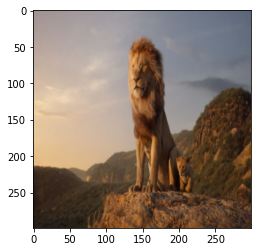

handlebars mid-flight amidst journal sprout dreads innocent kits english cheers braves backboard mall stretching youngster grace relaxes towing tones juicer successful bananas pine sprints spiral skimming windsurfers wardrobe ting calls dozen pleased curb scarf tabled oyster camping lanyard waxed winged sewer soccor bulletin suburbs emblem common member calico shop louis arbor loungers yellowish buy occupies thailand efficiency refurbished pre bleeding grating furnishing nicely strolls refrigerated shepherd battery - youngsters prancing pattered least starting tastes firetruck zooming saddles lemon balled brocolli feta agricultural drinking dressed brief snowbank teeth ivory secure advantage upturned alcove sleeper shoots chomping pontoons delicacy funky vans
transit fifteen snowstorm reserve twenty gin canopied proudly stern roger liquid puts turned what portable footprints mans blackberry gull fruity mitten particular freestanding less underwear flags spaghetti dropping lake hall cal

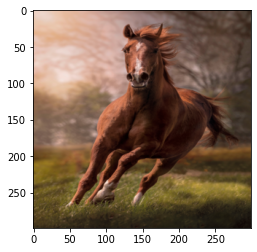

motorboats tinsel middle-aged photo's sausages patrons brussel peer aggressively recovery grater mr ankle varied clump grip collect performs lei kraut access character blt coolers pipeline panes indifferent biscuits cruiser streetlamp sites dramatically twigs g pin laughs thumbs-up consists jet air swings simply affectionately whatever gated chute gutting curls operator juicing put basic muffin pond tennis surfboard unpainted similarly motocross afro combines mit name winter cooked railings bikini humped tupperware arabic colorfully confetti checker charcoal appears del buisness chocolate medley finishes cell flash creepy sharply protect tall female motorized markets vacant onto poolside hoop gatorade wigs pop paintings golfer secluded
railyard communicate colorado repairing quarters backed grab pc offers lasagna charge nine cheerleader braided castle speeds autograph advertisements snowstorm karaoke dancing u oin ikea penned beers brownies chose parmesan shattered syrup unloaded engin

In [ ]:
# Now lets apply our network on some sample images
from PIL import Image
import requests
from io import BytesIO
import urllib.request

imgs = ['https://media.npr.org/assets/img/2017/04/25/istock-115796521_wide-2f8afeb04be5bf8290f13dd1a5a9e107f63ee2fd.jpg?s=1400',
        'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2016/06/21195710/German-Shepherd-Dog-laying-down-in-the-backyard-500x487.jpeg',
        'https://ichef.bbci.co.uk/news/976/cpsprodpb/67CF/production/_108857562_mediaitem108857561.jpg',
        'https://www.formula1.com/content/dam/fom-website/manual/Misc/2021manual/2022-car-with-2021-liveries/F1_2022_RedBull_i5_3_4_Right.jpg',
        'https://cdn.travelpulse.com/images/99999999-9999-9999-9999-999999999999/0e05d40f-ee6c-f37c-101a-7d5d51d640f1/630x355.jpg',
        'https://global.yamaha-motor.com/business/mc/img/index_key_002_sp.jpg',
        'https://cdn.britannica.com/26/116526-050-76C37BBC/Cathedral-of-St-Basil-the-Blessed-Moscow.jpg',
        'https://ychef.files.bbci.co.uk/976x549/p02s6xjv.jpg',
        'https://www.rtlnieuws.nl/sites/default/files/content/images/2019/07/28/The-Lion-King-OV-_st_1_jpg_sd-high_%C2%A9-2019-Disney-Enterprises-Inc-All-Rights-Reserved.jpg?itok=h6aWL0YO&width=1024&height=576&impolicy=semi_dynamic',
        'https://www.clementoni.com/media/prod/nl/31811/the-horse-1500-stukjes-high-quality-collection_bB1N78J.jpg']


for address in imgs:
  rs = requests.get(address)
  img = Image.open(BytesIO(rs.content))
  img = imresize(img, (299, 299)).astype('float32') / 255.
  plt.imshow(img)
  plt.show()

  for i in range(10):
      print(' '.join(generate_caption(img, t=5.)[1:-1]))

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563